# 피마 당뇨병 데이터

## Description   

피마 인디언은 세계에서 당뇨병 발병률이 가장 높은 종족으로  
피마 족의 남자 63% 여자 70%가 당뇨병에 걸렸다는 보고.   
피마 인디언은 본래 식물 위주의 식습관뿐만 아니라  
먹을 것이 풍족하지 못한 상황이었다.  
따라서 조금만 먹어도 잘 생존할 수 있도록   
유전자가 진화해왔다. 그러나 미국으로 이주한 그들의  
식생활이 서구화되면서, 풍족한 먹을 것에 피마 인디언의  
유전자가 비만을 초래하면서 당뇨병 등 성인병을 초래하게 된다.   

따라서 나는 피마 인디언의 dataset을 가지고, 피마 인디언 여성의 정보를 이용하여,  
피마인디언 여성의 당뇨 여부를 진단하는 머신러닝 기반 예측모델을 만드려고 한다.  

In [215]:
library(tidyverse)
library(data.table)
library(gridExtra)
library(ggplot2)
library(RColorBrewer)
library(gridExtra)
library(reshape2)

In [73]:
data<-fread("diabetes.csv")

# 기술통계량 Outline 및 간단한 전처리

데이터에 있는 모든 개체들은 여자들임

In [74]:
head(data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0


In [75]:
summary(data)

  Pregnancies        Glucose      BloodPressure    SkinThickness  
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
    Insulin           BMI        DiabetesPedigreeFunction      Age       
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780           Min.   :21.00  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437           1st Qu.:24.00  
 Median : 30.5   Median :32.00   Median :0.3725           Median :29.00  
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719           Mean   :33.24  
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262           3rd Qu.:41.00  
 Max.   :846.0   Max.   :67.10   Max.   :2.4200           Max.   :81.00  
    Outcome  

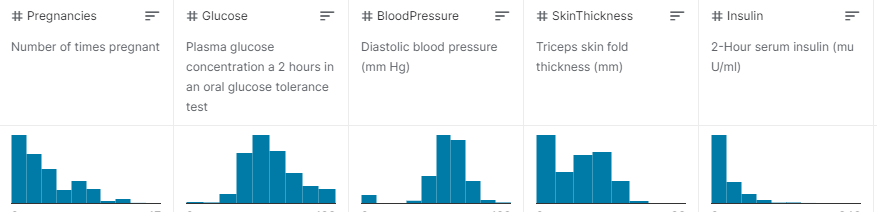

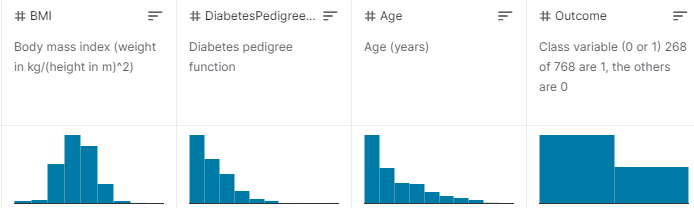

In [ ]:
# 나이 그룹별로 통게량 확인을 위해 나이 열 추가
data[,AgeGroup := Age %/% 10]

In [77]:
#고령자들 데이터 3개 제거.
data <- data[AgeGroup<7]

In [121]:
scatter_d <- function(df, col1, col2, ...) {
    graph <- ggplot(df, aes(x = get(col1), y = get(col2))) + 
    geom_point(shape = 20, size = 5, aes(colour = factor(get(...)))) + 
    ggtitle(paste("Scatter Plot :",col1,"between",col2)) + 
    labs(colour = paste(...), x = col1, y = col2)
    
    graph + scale_fill_brewer(palette = "Set1")
    return(graph)
}

In [115]:
Boxplot <- function(df, col1) {
    graph <- ggplot(df, aes(x = 1, y = get(col1))) +
    geom_boxplot() +
    ggtitle(paste("Boxplot of",col1)) + 
    labs(x = "value", y = col1)
    
    return(graph)
}

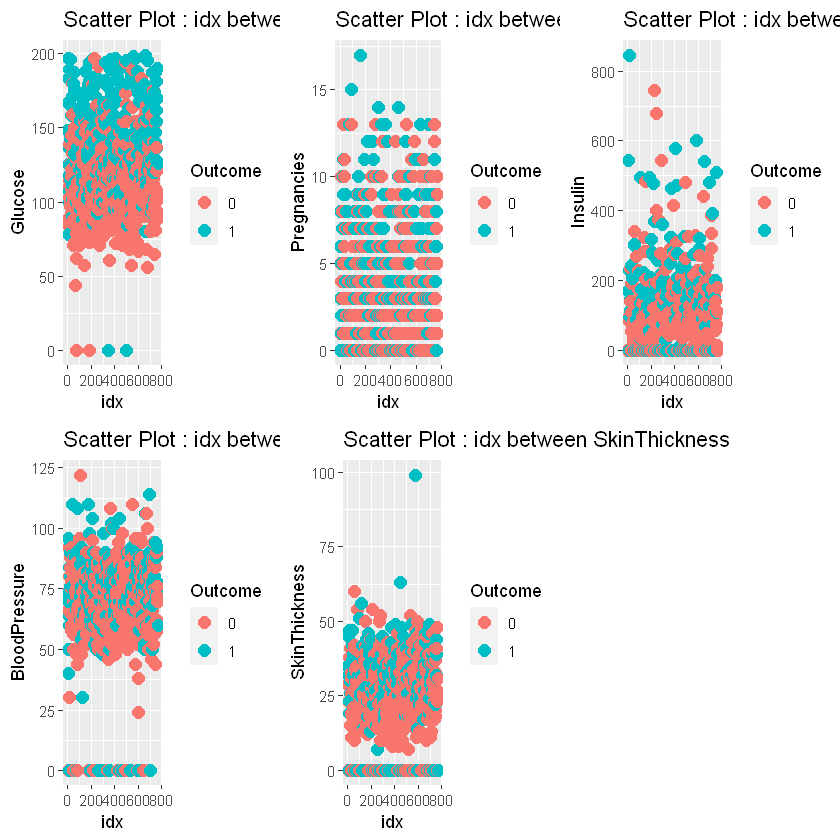

In [111]:
sca_graph_list <- list()
cols <- c("Glucose", "Pregnancies", "Insulin", "BloodPressure",
         "SkinThickness")

for (i in 1:length(cols)){
  sca_graph_list[[i]] = scatter_d(data, "idx", cols[i], "Outcome")
}

do.call("grid.arrange", c(sca_graph_list, ncol = 3, nrow = 2))

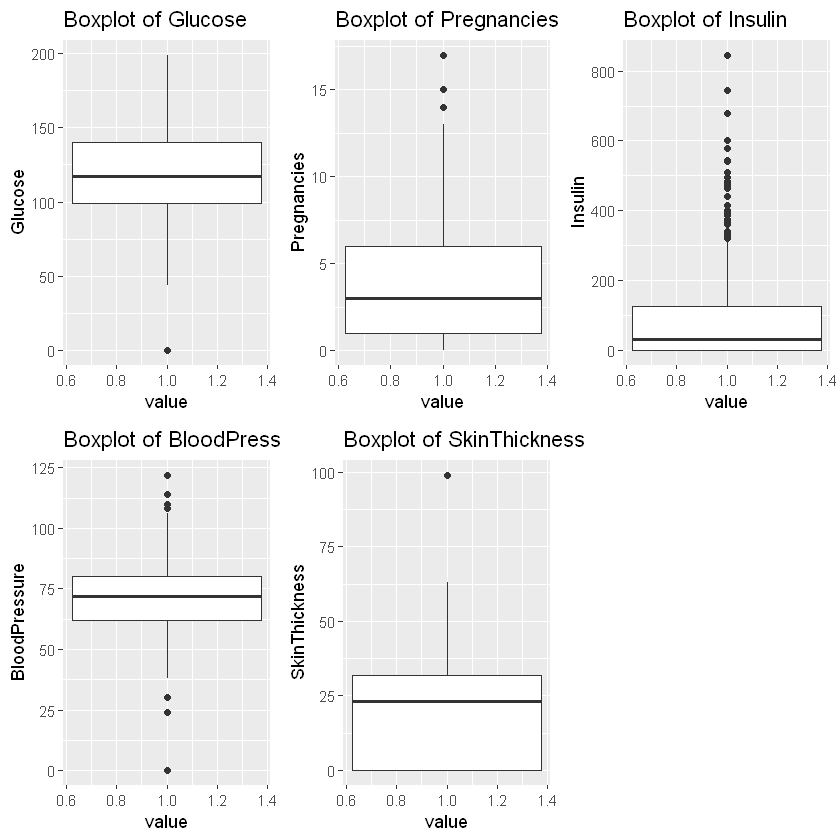

In [118]:
box_graph_list <- list()
cols <- c("Glucose", "Pregnancies", "Insulin", "BloodPressure",
         "SkinThickness")

for (i in 1:length(cols)){
  box_graph_list[[i]] = Boxplot(data, cols[i])
}

do.call("grid.arrange", c(box_graph_list, ncol = 3, nrow = 2))

# 혈압 및 BMI 변수 처리

혈압의 연령별 평균이 다르고,   
2~40대의 경우 혈압의 결측값이 많기 때문에,    
혈압 결측값 연령별 혈압 중위수로 대체    
why 중위수? 평균과 그렇게 차이 안나고 깔끔한 값  

In [78]:
data[BloodPressure!=0,mean(BloodPressure),AgeGroup][order(AgeGroup)]
data[BloodPressure!=0,median(BloodPressure),AgeGroup][order(AgeGroup)]

AgeGroup,V1
<dbl>,<dbl>
2,68.82447
3,73.68590
4,77.21239
5,79.80702
6,78.27586


AgeGroup,V1
<dbl>,<dbl>
2,68
3,74
4,78
5,78
6,78


In [81]:
data[BloodPressure == 0 & AgeGroup == 2, BloodPressure := 68]
data[BloodPressure == 0 & AgeGroup == 3, BloodPressure := 74]
data[BloodPressure == 0 & AgeGroup == 4, BloodPressure := 78]

BMI 0으로 나온 값들 다 연령별 평균으로 대체    
정규분포모양으로 생겨서 평균으로 대체하였음

In [39]:
data[BMI != 0, mean(BMI), AgeGroup][order(AgeGroup)]
data[BMI != 0, median(BMI), AgeGroup][order(AgeGroup)]

AgeGroup,V1
<dbl>,<dbl>
2,32.03763
3,32.67012
4,34.61780
5,31.89821
6,29.73571


AgeGroup,V1
<dbl>,<dbl>
2,31.60
3,32.00
4,33.95
5,33.05
6,29.30


In [84]:
data[BMI==0 & AgeGroup == 2, BMI:=32.04]
data[BMI==0 & AgeGroup == 3, BMI:=32.67]
data[BMI==0 & AgeGroup == 5, BMI:=31.90]
data[BMI==0 & AgeGroup == 6, BMI:=29.74]

In [86]:
# BMI 그룹별로 나누는 변수 추가
data[,BMI_cat := ifelse(BMI < 18.5,"uw",ifelse(BMI<25,"nm",ifelse(BMI<30,"ow","ob")))]
# row index 추가
data[, idx := seq(1,764)]

# Glucose 결측값 처리

In [120]:
data[Glucose == 0]

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,BMI_cat,idx
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>


In [119]:
data[Glucose == 0 & BloodPressure == 48, Glucose:=98]
data[Glucose == 0 & BloodPressure == 74, Glucose:=89]
data[Glucose == 0 & BMI == 32.0, Glucose:=109]
data[Glucose == 0 & BMI == 39, Glucose:=158]
data[Glucose == 0 & BloodPressure == 80, Glucose:=140]

글루코오스 같은 경우, 결측치가 5개 행밖에 없기 때문에  
가장 결측 행과 비슷한 행의 값들을 찾아 단일일 땐 그 값을 적고  
그 외에는 평균을 하고, 반올림 처리 하여 결측을 채웠다.   

추가적으로 알아낸 사실은 인슐린과 글루코오스간 관계가 있어보여서 히스토그램을 그려볼 것이다.  
만일 관계가 있다면 Insulin의 많은 결측값도 채워볼 수 있지 않을까 싶다.  

# Insulin 변수 처리 .. 난관..

일단 변수에 0이 너무 많아서 분명 결측치도 있을 것이라고 생각하지만   
일단 스킵한다.  

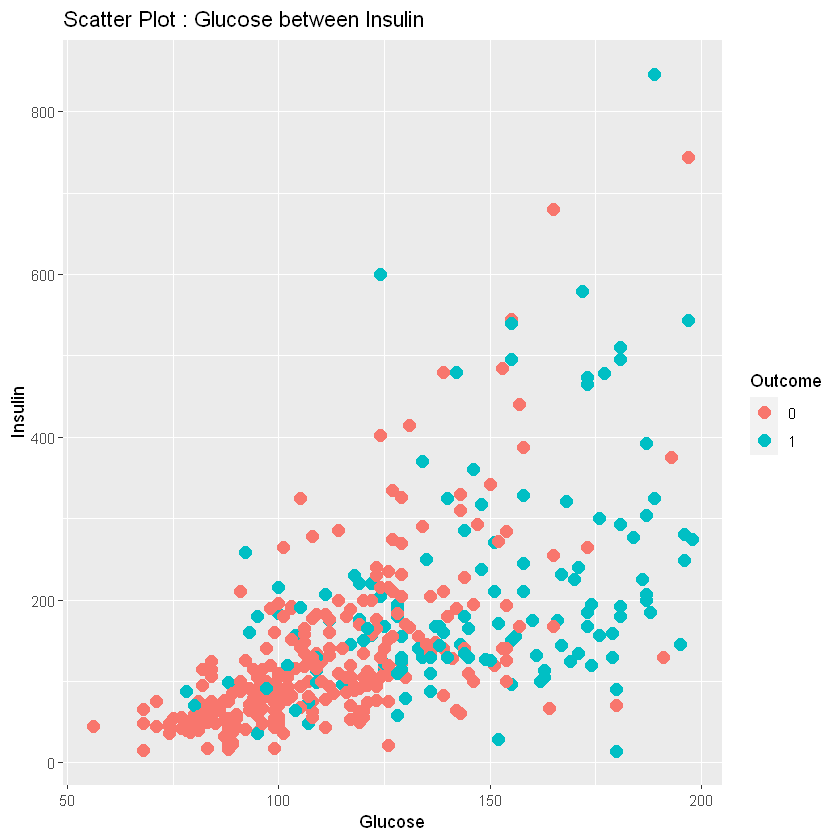

In [125]:
scatter_d(data[Insulin != 0], "Glucose", "Insulin", "Outcome")

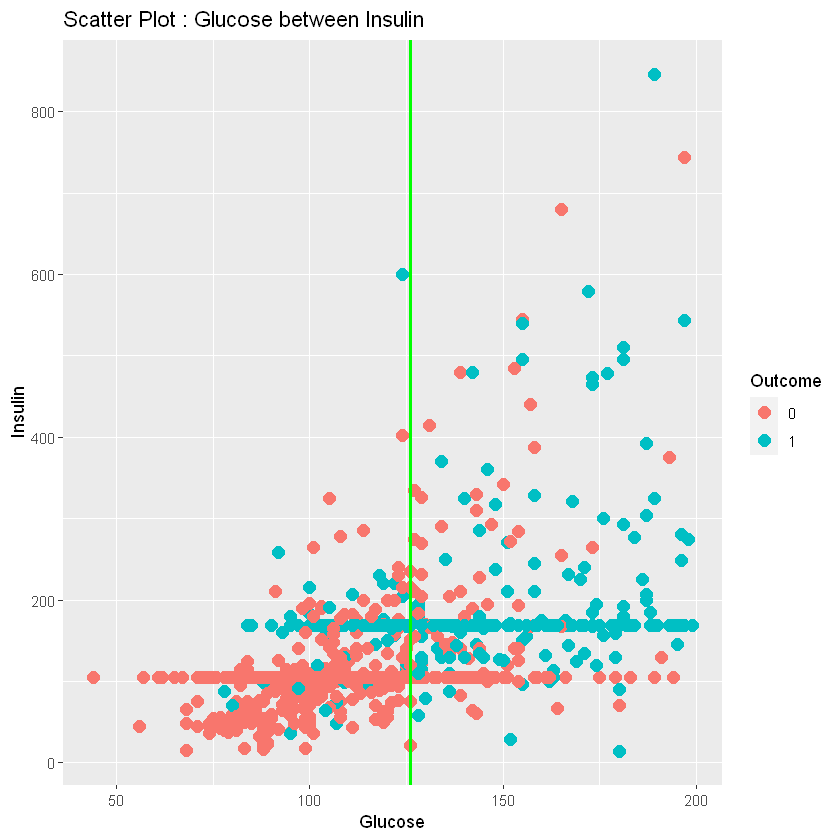

In [195]:
scatter_d(data, "Glucose", "Insulin", "Outcome") + geom_vline(xintercept = 126, col = "green", size = 1)

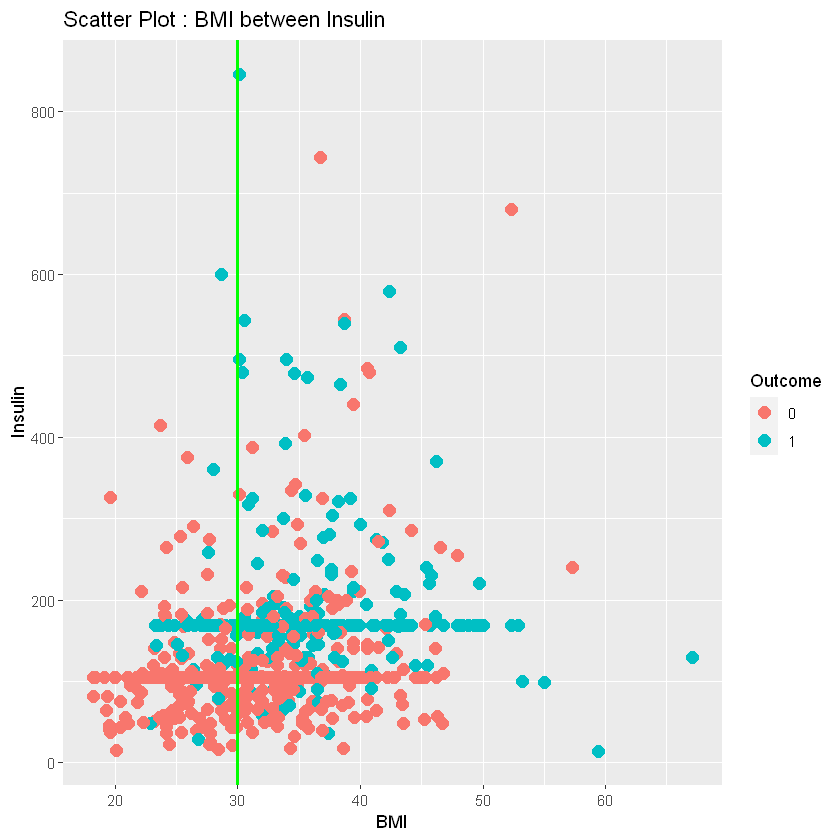

In [194]:
scatter_d(data[Insulin != 0], "BMI", "Insulin", "Outcome") + geom_vline(xintercept = 30, col = "green", size = 1)

모르겠고,, insulin은 당뇨 아닌사람과 당뇨인 사람의 값의 메디안을 채우겠다.

In [179]:
data[Insulin != 0, median(Insulin), by = Outcome]

Outcome,V1
<int>,<dbl>
0,105.0
1,169.5


In [182]:
data[Insulin == 0 & Outcome == 0, Insulin:= 105.0]
data[Insulin == 0 & Outcome == 1, Insulin:= 169.0]

인슐린의 정상 수치 범위는 공복 시 5\~15이며, 인슐린 저항성이   
있는 경우 15\~40

# SkinThickness 변수 처리

이런 경우는 BMI수치에 따라 SkinThickness가 관계를 가지므로,   
회귀분석을 실행하여 SkinThickness값을 채워주도록 하겠음..!!  

In [165]:
rline <- lm(data[SkinThickness!=0,SkinThickness]~data[SkinThickness!=0,BMI])

In [166]:
rline


Call:
lm(formula = data[SkinThickness != 0, SkinThickness] ~ data[SkinThickness != 
    0, BMI])

Coefficients:
                  (Intercept)  data[SkinThickness != 0, BMI]  
                      -3.4650                         0.9878  


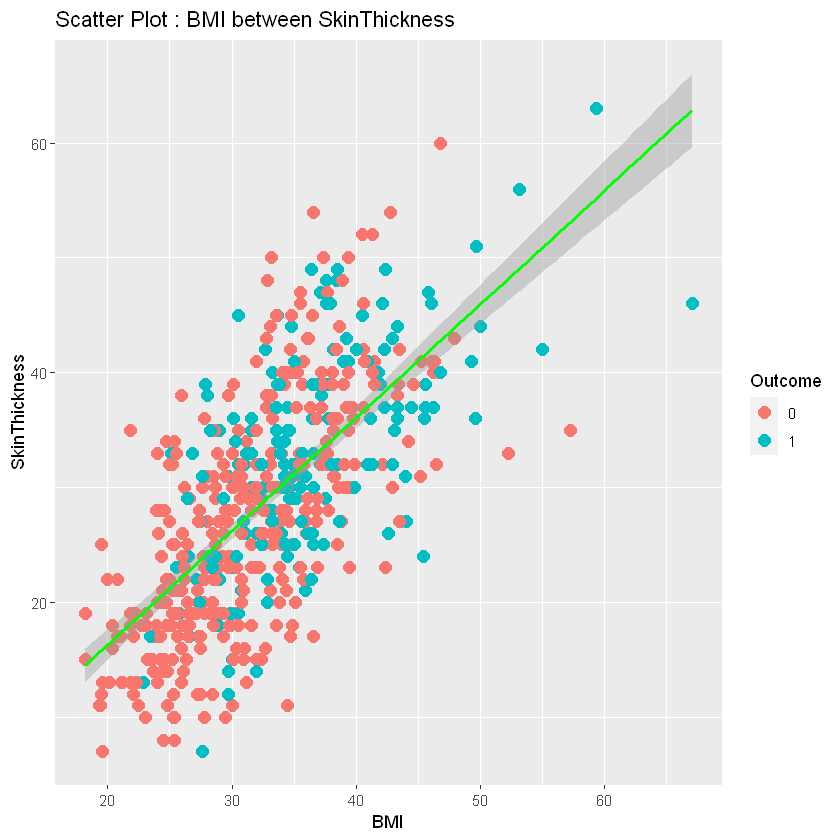

In [167]:
scatter_d(data[SkinThickness!=0], "BMI", "SkinThickness", "Outcome") +
    geom_smooth(method = 'lm', formula = y~x, color = "green")

In [162]:
# 아웃라이어 제거
data <- data[idx != 578]

In [171]:
# StickThickness 값 채우기
data[SkinThickness == 0 , SkinThickness := round(-3.4650 + 0.9878*BMI)]

In [184]:
head(data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,BMI_cat,idx
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>
6,148,72,35,169,33.6,0.627,50,1,5,ob,1
1,85,66,29,105,26.6,0.351,31,0,3,ow,2
8,183,64,19,169,23.3,0.672,32,1,3,nm,3
1,89,66,23,94,28.1,0.167,21,0,2,ow,4
0,137,40,35,168,43.1,2.288,33,1,3,ob,5
5,116,74,21,105,25.6,0.201,30,0,3,ow,6


In [226]:
#상관계수 heatmap 그리기..!!
temp <- data[, c(1,2,3,4,5,6,7,8)]
cormat <- round(cor(temp),2)
cormat

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.00,0.13,0.21,0.08,0.06,0.02,-0.03,0.56
Glucose,0.13,1.00,0.23,0.20,0.49,0.24,0.14,0.27
BloodPressure,0.21,0.23,1.00,0.23,0.07,0.29,0.00,0.34
SkinThickness,0.08,0.20,0.23,1.00,0.20,0.74,0.13,0.08
Insulin,0.06,0.49,0.07,0.20,1.00,0.23,0.15,0.13
BMI,0.02,0.24,0.29,0.74,0.23,1.00,0.16,0.04
DiabetesPedigreeFunction,-0.03,0.14,0.00,0.13,0.15,0.16,1.00,0.03
Age,0.56,0.27,0.34,0.08,0.13,0.04,0.03,1.00


In [227]:
get_lower_tri <- function(cormat){
    cormat[upper.tri(cormat)] <- NA
    return(cormat)
}
get_upper_tri <- function(cormat){
    cormat[lower.tri(cormat)] <- NA
    return(cormat)
}
reorder_cormat <- function(cormat){
    # Use correlation between variables as distance
    dd <- as.dist((1-cormat)/2)
    hc <- hclust(dd)
    cormat <-cormat[hc$order, hc$order]
}
upper_tri <- get_upper_tri(cormat)
melted_cormat <- melt(upper_tri,na.rm = TRUE)

In [228]:
heatmap <- function(melted_data){
    graph <- ggplot(data = melted_data, aes(Var2, Var1, fill = value)) +
    geom_tile(color = "white") + 
    scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                        midpoint = 0, limit = c(-1,1), space = "Lab",
                        name = "Pearson\nCorrelation") + 
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 12, hjust = 1)) +
    coord_fixed()
    return(graph)
} 

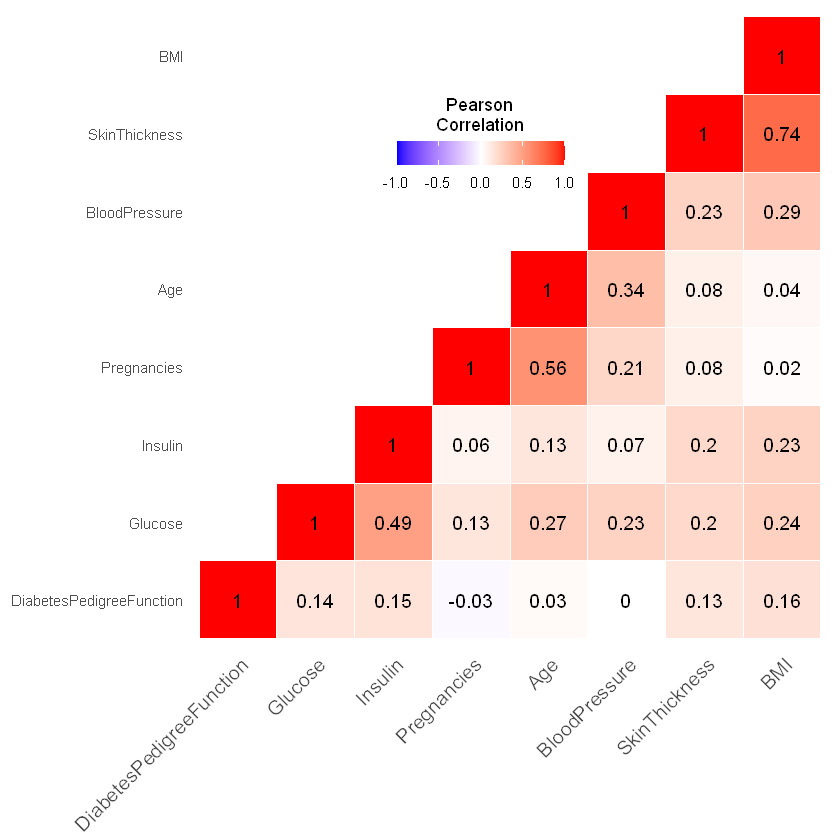

In [229]:
cormat <- reorder_cormat(cormat)
upper_tri <- get_upper_tri(cormat)
melted_cormat <- melt(upper_tri, na.rm = TRUE)
heatmap(melted_cormat) + 
geom_text(aes(Var2, Var1, label = value), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.7),
  legend.direction = "horizontal")+
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
                title.position = "top", title.hjust = 0.5))

+ 이전에 EDA로 살펴보았던 그래프들이 역시 상관계수가 높게 나왔음.   
+ Pregnancy와 Age는 한번 봐볼 필요가 있음.

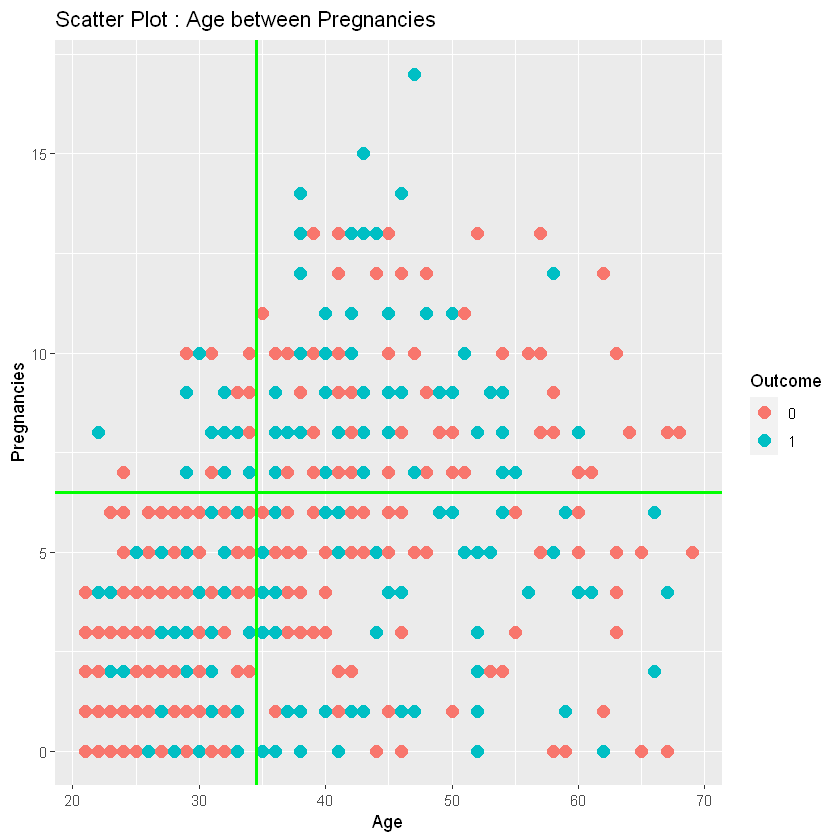

In [236]:
scatter_d(data, "Age","Pregnancies","Outcome") + 
    geom_vline(xintercept = 34.5, col = "green", size = 1) + 
    geom_hline(yintercept = 6.5, col = "green", size = 1)

좌측 하단을 보면 대부분의 데이터가 몰려있는 것을 확인할 수 있고,     
당뇨가 아닌 사람들이 집중적으로 포진되어 있음   
따라서 이 부분을 새로운 변수로 만들어볼만 함 !!

# 추가로 더해줄만한 변수

In [190]:
# 연령별 당뇨병 비율
data[Outcome == 1,.N,by = AgeGroup][order(AgeGroup)][,2] / data[,.N,AgeGroup][order(AgeGroup)][,2]
data[AgeGroup != 8][,.N,AgeGroup][order(AgeGroup)]

N
<dbl>
0.2121212
0.4606061
0.5508475
0.5964912
0.2500000


AgeGroup,N
<dbl>,<int>
2,396
3,165
4,118
5,57
6,28


In [200]:
#위험군인 30~50대에 1을 부여
data[,D1 := ifelse(AgeGroup %in% c(2,6),0,1)]

20대와 60대의 당뇨 비율 낮고 30대와 50대 사이  
당뇨 비율이 높음 따라서 20,60 과 30\~50으로 0,1 더미 변수 만듬

In [193]:
# BMI별 당뇨병 비율
data[Outcome == 1, .N, by = BMI_cat][order(BMI_cat)][,2] / data[BMI_cat!="uw",.N,by = BMI_cat][order(BMI_cat)][,2]
data[, .N, by = BMI_cat][order(BMI_cat)]

N
<dbl>
0.06930693
0.45625000
0.22346369


BMI_cat,N
<chr>,<int>
nm,101
ob,480
ow,179
uw,4


In [204]:
#위험군인 과체중쪽에 1을 부여
data[,D2 := ifelse(BMI_cat %in% c("uw","nm"),0,1)]

전반적으로 무게가 많이 나가는 사람이 많이 조사되었고,   
피마 인디언은 무게가 많이 나가는 사람이 많은가 보다.  
비만 --> 과체중 --> 저체중 --> 정상 순으로   
당뇨병 비율이 높았음.

(OverWeight, Obese) , (normal, underweight)로 더미변수 만들자

In [230]:
# 혈당 수치 126 이상인 부분을 1로 코딩한 더미변수 부여
data[,D3 := ifelse(Glucose < 126,0,1)]

In [237]:
# 임신여부와 나이를 고려한 추가변수.
data[,D4 := ifelse(Age < 35,ifelse(Pregnancies < 7,0,1),1)]

In [239]:
head(data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,AgeGroup,BMI_cat,idx,D1,D2,D3,D4
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,169,33.6,0.627,50,1,5,ob,1,1,1,1,1
1,85,66,29,105,26.6,0.351,31,0,3,ow,2,1,1,0,0
8,183,64,19,169,23.3,0.672,32,1,3,nm,3,1,0,1,1
1,89,66,23,94,28.1,0.167,21,0,2,ow,4,0,1,0,0
0,137,40,35,168,43.1,2.288,33,1,3,ob,5,1,1,1,0
5,116,74,21,105,25.6,0.201,30,0,3,ow,6,1,1,0,0


In [240]:
setcolorder(data, c(12,1,2,3,4,5,6,7,8,13,14,15,16,9))

In [242]:
data <- data[,c(1:14)]

In [255]:
#전처리 끝 최종 dataset
head(data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,D1,D2,D3,D4,Outcome
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
6,148,72,35,169,33.6,0.627,50,1,1,1,1,1
1,85,66,29,105,26.6,0.351,31,1,1,0,0,0
8,183,64,19,169,23.3,0.672,32,1,0,1,1,1
1,89,66,23,94,28.1,0.167,21,0,1,0,0,0
0,137,40,35,168,43.1,2.288,33,1,1,1,0,1
5,116,74,21,105,25.6,0.201,30,1,1,0,0,0


# 학습 모델용 데이터 분할 및 처리

In [278]:
library(randomForest)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:dplyr':

    combine


The following object is masked from 'package:ggplot2':

    margin




In [274]:
#copy datatable
data.copy <- copy(data)

# whitening
data[,c(1:8) := lapply(.SD,'scale'), .SDcols = c(1:8)]
data

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,D1,D2,D3,D4,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.6397165,0.86935618,-0.02746393,0.70839244,0.29785633,0.16417589,0.46835679,1.480647754,1,1,1,1,1
-0.8431215,-1.19945879,-0.52116855,0.05789746,-0.42202816,-0.85419942,-0.36344998,-0.178281144,1,1,0,0,0
1.2328518,2.01869783,-0.68573676,-1.02626084,0.29785633,-1.33429064,0.60397746,-0.090969096,1,0,1,1,1
-0.8431215,-1.06810546,-0.52116855,-0.59259752,-0.54575831,-0.63597614,-0.91798783,-1.051401616,0,1,0,0,0
-1.1396892,0.50813452,-2.66055524,0.70839244,0.28660814,1.54625666,5.47426641,-0.003657049,1,1,1,0,1
0.3431489,-0.18147047,0.13710427,-0.80942918,-0.42202816,-0.99968161,-0.81551888,-0.265593191,1,1,0,0,0
-0.2499863,-1.42932712,-1.83771420,0.38314495,-0.61324748,-0.21407780,-0.67387063,-0.614841380,0,1,0,0,1
1.8259870,-0.21430881,-0.35660035,0.27472912,-0.42202816,0.41149560,-1.01744299,-0.352905238,0,1,0,1,0
-0.5465539,2.47843448,-0.19203214,1.79255074,4.50468135,-0.28681889,-0.94511197,1.742583895,1,1,1,1,1


In [275]:
# train_test split
sample_size <- floor(0.7*nrow(data))

set.seed(123)
train_ind <- sample(seq_len(nrow(data)),size = sample_size)

x_train <- data[train_ind, 1:12]
y_train <- data[train_ind, 13]
x_test <- data[-train_ind, 1:12]
y_test <- data[-train_ind, 13]

In [279]:
rf_model1 <- randomForest(x_train, y_train, x_test, y_test, ntree = 40, mtry = 5, importance = TRUE, proximity = TRUE)
print(rf_model1)

Warning message in randomForest.default(x_train, y_train, x_test, y_test, ntree = 40, :
"The response has five or fewer unique values.  Are you sure you want to do regression?"


ERROR: Error in randomForest.default(x_train, y_train, x_test, y_test, ntree = 40, : length of response must be the same as predictors
